#Imports and Read file

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
data = pd.read_csv('Kaggle_Salary.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (73,77,114,146,153,171,175,212,224,228,231) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Cleaning

The raw data has 12497 entries and 248 features in total. In order to process cleaned data for machine learning algorithm implementation. We need to look inside the dataset. What I did next is to get the basic numerical report for missing values in each column.

In [3]:
print("The raw data has total:",data.isnull().values.sum(),"missing values")
miss_value_count = data.isnull().sum()
missing_values_visualization = pd.DataFrame(data=miss_value_count).T
missing_values_visualization

The raw data has total: 2176806 missing values


,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,0,0,0,0,0,0,0,0,0,0,0,6518,8990,7607,9212,8863,10194,11982,12258,0,0,247,9712,11111,10093,4740,9680,7381,10853,5164,9003,10616,12123,11614,0,10219,6010,10058,9519,11940,...,12079,11916,11911,12125,12059,12097,12232,12182,11928,8184,12272,0,11999,12220,12306,12326,12321,12032,11741,12218,12469,12364,7322,12365,0,9375,10337,10970,10645,11305,11950,11909,12082,12018,11971,11252,12210,0,0,0


From the dataframe above we can clearly see that the raw dataset has 2176806 entries missing value. Some columns does not have a single missing value while some other columns has more than 10,000 missing values(>80%).


## Removing text columns

After carefully go though the raw dataset, I found that there are some columns named "QXX_OTHER_TEXT". They do not have actual meaning so that I decided to drop these columns first. Removing the text columns because text answers in csv is meaningless.

In [4]:
col_ = []
for col in data.columns:
  if (col[-4:]=='TEXT'):
    col_.append(col)
#there are 28 columns are "Qxx_OTHER_TEXT" in totall
data = data.drop(columns= col_)
data.shape

(12497, 220)

##Encoding multi-parts questions

The majority of NAN distributed at questions which have multiple parts, for these questions, there is a large number of missing values if the surveyee only picked one choice or few choices for each question. For instance, for the surveyee who selected 2 choice in question 32, there were 10 missing responses in question 32 because question 32 have total 12 parts.

Below are the steps to deal with features which have multiple parts. For the questions have multiple parts, I did the following:

I created The function *one_hot_encoding* below that encodes data which have multiple parts question. It also fills individual cells in the dataframe.


1.    More specifically, the function fills NaN values. If there is an NAN, converts it to 0 fristly.

2.   There is a special characteristic for those multi-parts questions, the last two columns is the option for **"Other"** and **"None"**. The function i created below check if the surveyee selected 'none' or 'other', which means that this unique entry(surveyee) does not answer previous part. I will fill NONE and OTHER with a numerical value 100, doing this because I will merge these multiparts questions into one column, if there is an 'none' or 'other' exist, the **merged column** cell will be converted to 0. I will explain this later in detail.

3.   Converts all text to numerical value 1.

4.   The function lastly will return a dataframe which only belongs one question. For example, if I put Q9 into this function, the output will be a dataframe, all text in Q9 will be converts to 1, all NAN will fill with 0, all 'none', 'other' will filled with 100. Number Columns are number of parts for each question originally.


In [0]:
def one_hot_encoding (column, part_starting, part_ending, none_col,other_col):
    range_of_parts = list(range(part_starting,part_ending+1))
    #converts all NAN to 0
    for i in range (part_starting,part_ending+1):
      data[column+'_Part_'+str(i)] = data[column+'_Part_'+str(i)].fillna(0)


    #multi-parts questions have some columns filled by "none"/"other", replace "none"/"other" to 1.
    for i in range (part_starting,part_ending+1):
      if i == none_col:
        data[column+'_Part_'+str(i)] = data[column+'_Part_'+str(i)].replace('None',200)
        #####for Q9 specifically!#####
        data[column+'_Part_'+str(i)] = data[column+'_Part_'+str(i)].replace('None of these activities are an important part of my role at work',200)
        #####for Q9 specifically!#####
        data[column+'_Part_'+str(i)] = data[column+'_Part_'+str(i)].astype(int)
      elif i == other_col:
        data[column+'_Part_'+str(i)] = data[column+'_Part_'+str(i)].replace('Other',100)
        data[column+'_Part_'+str(i)] = data[column+'_Part_'+str(i)].astype(int)
      else:
        #converts text to 1
        data[column+'_Part_'+str(i)] = data[column+'_Part_'+str(i)].astype(bool).astype(int)
    #combining all columns within one question together
    for i in range(part_starting,part_ending+1):
      combined_column = pd.concat([data[column+'_Part_'+str(i)] for i in range_of_parts] ,axis=1)
    return combined_column

This function simply converts 100 to 0 because the original dataset does not need to have those 100 values. These special 100 values are used to merge columns in feature engineering part below.

In [0]:
def update_in_original_df(column, part_starting, part_ending):
  for i in range (part_starting,part_ending+1):
        #replace 'other' to numerical value 1
        data[column+'_Part_'+str(i)] = data[column+'_Part_'+str(i)].replace(100,1)
        #replace 'None' to numerical value 0
        data[column+'_Part_'+str(i)] = data[column+'_Part_'+str(i)].replace(200,0)

In [0]:
Q9 = one_hot_encoding('Q9',1,8,7,8)
Q12 = one_hot_encoding('Q12',1,12,11,12)
Q13 = one_hot_encoding('Q13',1,12,11,12)
Q16 = one_hot_encoding('Q16',1,12,11,12)
Q17 = one_hot_encoding('Q17',1,12,11,12)
Q18 = one_hot_encoding('Q18',1,12,11,12)
Q20 = one_hot_encoding('Q20',1,12,11,12)
Q21 = one_hot_encoding('Q21',1,5,0,5)
Q24 = one_hot_encoding('Q24',1,12,11,12)
Q25 = one_hot_encoding('Q25',1,8,7,8)
Q26 = one_hot_encoding('Q26',1,7,6,7)
Q27 = one_hot_encoding('Q27',1,6,5,6)
Q28 = one_hot_encoding('Q28',1,12,11,12)
Q29 = one_hot_encoding('Q29',1,12,11,12)
Q30 = one_hot_encoding('Q30',1,12,11,12)
Q31 = one_hot_encoding('Q31',1,12,11,12)
Q32 = one_hot_encoding('Q32',1,12,11,12)
Q33 = one_hot_encoding('Q33',1,12,11,12)
Q34 = one_hot_encoding('Q34',1,12,11,12)

In [0]:
update_in_original_df('Q9',1,8)
update_in_original_df('Q12',1,12)
update_in_original_df('Q13',1,12)
update_in_original_df('Q16',1,12)
update_in_original_df('Q17',1,12)
update_in_original_df('Q18',1,12)
update_in_original_df('Q20',1,12)
update_in_original_df('Q21',1,5)
update_in_original_df('Q24',1,12)
update_in_original_df('Q25',1,8)
update_in_original_df('Q26',1,7)
update_in_original_df('Q27',1,6)
update_in_original_df('Q28',1,12)
update_in_original_df('Q29',1,12)
update_in_original_df('Q30',1,12)
update_in_original_df('Q31',1,12)
update_in_original_df('Q32',1,12)
update_in_original_df('Q33',1,12)
update_in_original_df('Q34',1,12)

As a result of these, I should have as many columns as there are parts in a particular question, with either zeros or ones in each column. 

##Generating new features by combining multi_parts_question

As I mentioned before, I will merge those multi-parts question into one column for each question. This step is ***feature engineering part***, creating new features based on raw data.
Each output from function 'one_hot_encoding' is a dataframe, then, The function below will combine each datafram (belongs to one question) into one column. 

The basic logic behind this function is that simply sum each entry, 

*   If the summation is zero, meaning that this entry originally is an NAN.

*   If summation result greater or equal to 100, meaning that this entry(surveyee) selected 'none' or 'other' for this question, he/she did not answer any previous parts. Thus it should be converted to 0.



In [0]:
def combine_col(data,col_name,part_starting,part_ending):
  first = data[col_name+'_Part_'+str(part_starting)]
  second = data[col_name+'_Part_'+str(part_starting+1)]
  column_combined = first+second
  for i in range (part_starting+2,part_ending+1):
    next_col = data[col_name+'_Part_'+str(i)]
    column_combined = column_combined+next_col
#if the sum of columns equal to 0, which means this entry is originally a NAN entry
  column_combined = column_combined.replace(0,np.nan)
#if the sum of columns greater than 99, which means this entry originally is a "None" or "Other", replace it to 0
  column_combined[column_combined>99] = 0
  return column_combined

In [0]:
Q9_merged = combine_col(Q9,'Q9',1,8)
Q12_merged = combine_col(Q12,'Q12',1,12)
Q13_merged = combine_col(Q13,'Q13',1,12)
Q16_merged = combine_col(Q16,'Q16',1,12)
Q17_merged = combine_col(Q17,'Q17',1,12)
Q18_merged = combine_col(Q18,'Q18',1,12)
Q20_merged = combine_col(Q20,'Q20',1,12)
Q21_merged = combine_col(Q21,'Q21',1,5)
Q24_merged = combine_col(Q24,'Q24',1,12)
Q25_merged = combine_col(Q25,'Q25',1,8)
Q26_merged = combine_col(Q26,'Q26',1,7)
Q27_merged = combine_col(Q27,'Q27',1,6)
Q28_merged = combine_col(Q28,'Q28',1,12)
Q29_merged = combine_col(Q29,'Q29',1,12)
Q30_merged = combine_col(Q30,'Q30',1,12)
Q31_merged = combine_col(Q31,'Q31',1,12)
Q32_merged = combine_col(Q32,'Q32',1,12)
Q33_merged = combine_col(Q33,'Q33',1,12)
Q34_merged = combine_col(Q34,'Q34',1,12)

As a result, these new features also have NAN values we need look at it.

## Looking into Missing values in datasets

In this section, missing values will be handled. 
There are two dataframes need to be cleaned, which are:


1.   ***data_all***:This is the dataframe containing new features
2.   ***data***: This is the original raw dataset.

**data_all** dataframe has the new generated features, which later these new features will be added in Feature Selection part. 

**data** dataframe is the original dataset, all multiparts questions are already encoded with either 0 or 1 properly.


Basically, our raw data can devided into questions have multiparts and questions without multiparts.
Firstly, I concatenate the these two types data together called **data_all**. This dataframe contains new features generated by merging multiparts question into one column and the questions without multiparts.

In [0]:
multipart_column_encoded = pd.DataFrame(data=[Q9_merged,Q12_merged,Q13_merged,Q16_merged,Q17_merged,Q18_merged,
                                      Q20_merged,Q21_merged,Q24_merged,Q25_merged,Q26_merged,Q27_merged,Q28_merged,
                                      Q29_merged,Q30_merged,Q31_merged,Q32_merged,Q33_merged,Q34_merged]).T
multipart_column_encoded.columns = ['Q9','Q12','Q13','Q16','Q17','Q18','Q20','Q21','Q24','Q25',
                                    'Q26','Q27','Q28','Q29','Q30','Q31','Q32','Q33','Q34']

In [0]:
question_without_multipart = pd.DataFrame(data=[data['Q1'],data['Q2'],data['Q3'],data['Q4'],data['Q5'],data['Q6'],
                                          data['Q7'],data['Q8'],data['Q10'],data['Q11'],data['Q14'],data['Q15'],
                                          data['Q19'],data['Q22'],data['Q23'],data['Q10_Encoded'],
                                          data['Q10_buckets']]).T

In [0]:
data_all = pd.concat([question_without_multipart,multipart_column_encoded],axis=1)
#(12497, 36)

Visualize missing value distribution in dataframe "data_all".

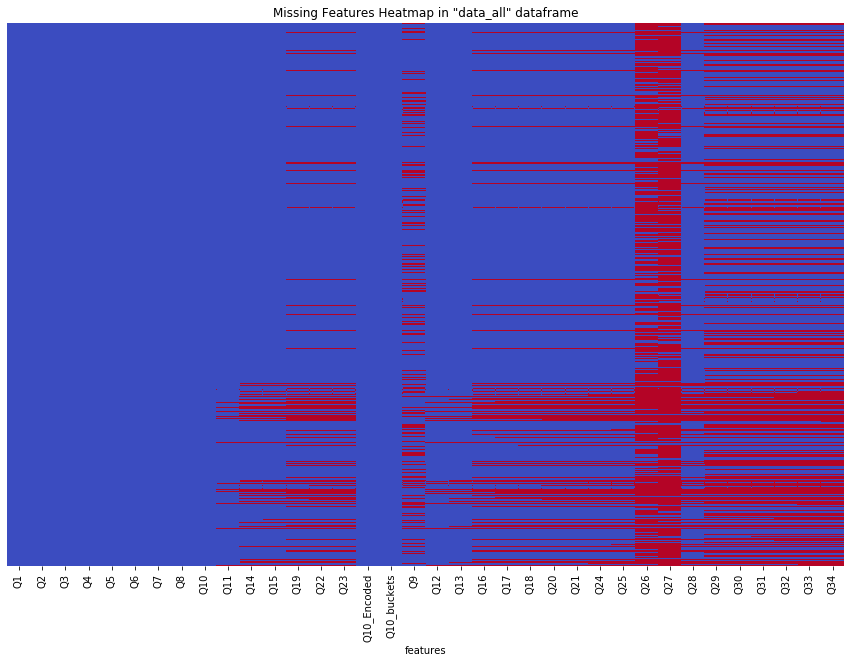

In [14]:
plt.figure(figsize=(15,10))
missing_values_heatmap = sns.heatmap(data_all.isnull(),cmap='coolwarm',yticklabels=False,cbar=False)
plt.xlabel("features")
plt.title('Missing Features Heatmap in "data_all" dataframe')
plt.xticks(rotation=90)
plt.show()

Visualize missing value distribution in dataframe "data".

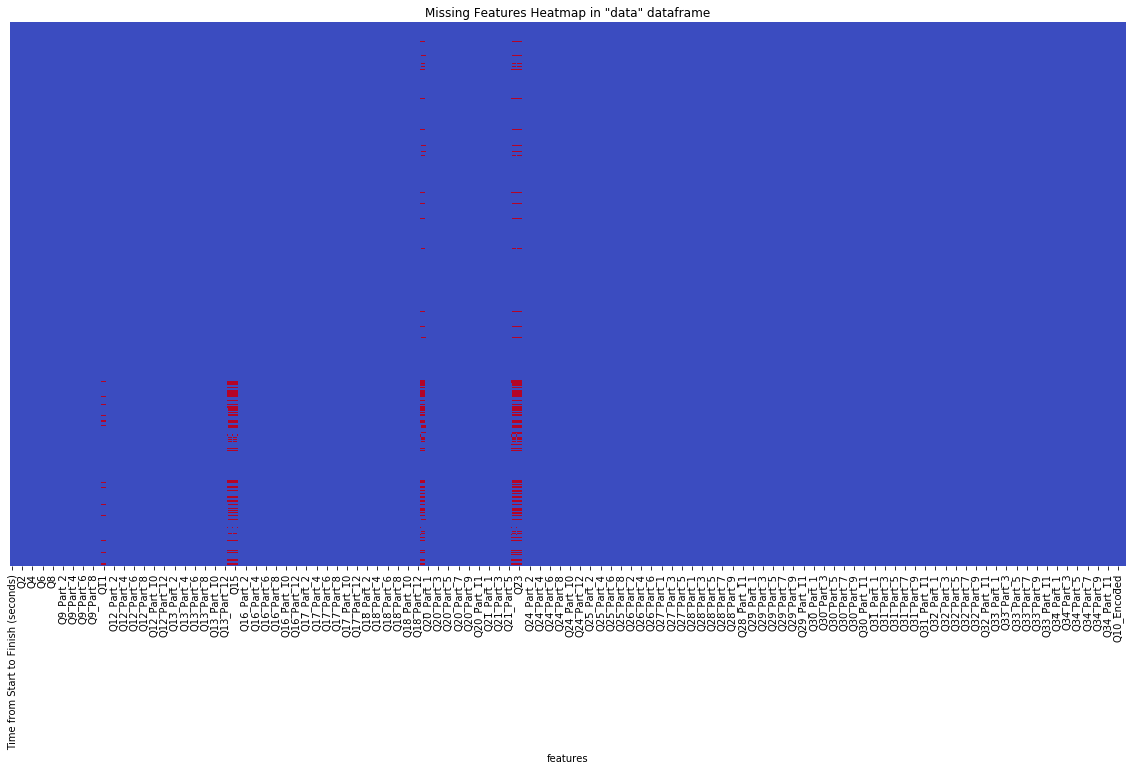

In [15]:
plt.figure(figsize=(20,10))
missing_values_heatmap = sns.heatmap(data.isnull(),cmap='coolwarm',yticklabels=False,cbar=False)
plt.xlabel("features")
plt.title('Missing Features Heatmap in "data" dataframe')
plt.xticks(rotation=90)
plt.show()

##Handle Missing values

I came up two ways to deal with missing values in dataset:


*   Drop the entire *column* if this particular column has more than 20% missing values.
*   Drop the entire *row* if this particular row has more than 20% missing values

I created two dropping functions below, which are used to calculate percentage of missing value take part in each row/column. Then I manualy set up a threshold(20%), which means if percentage of missing value in each row/column greater than 20%, that row/column will be dropped.


---



**Note**: the input dataframe is "data_all", however, the original dataset "data" will be updated simultaneously with "data_all" once the function being called.



In [0]:
def drop_column(dataframe,drop_threshold):
  total_number_incolumn = data_all.shape[0]
  for column in list(dataframe.columns):
    missing_number = dataframe[column].isna().sum()
    missing_percentage = round(100*(missing_number/total_number_incolumn),3)
    if missing_percentage >= drop_threshold:
      dataframe = dataframe.drop([column],axis=1)
      data.drop([col for col in data.columns if column in col],axis=1,inplace=True)#update in original dataset
  return dataframe

In [17]:
cleaning_phrase1_dataset = drop_column(data_all,20)
cleaning_phrase1_dataset.shape
#there are still a lot of missing values in rows.

(12497, 27)

In [0]:
def drop_row(dataframe,threshold):
    total_number_inrow = data_all.shape[1]
    for (rowidx,rowdata) in dataframe.iterrows():
      missing_number = dataframe.loc[rowidx].isna().sum()
      missing_percentage = round(100*(missing_number/total_number_inrow),3)
    
      if missing_percentage >= threshold:
        dataframe = dataframe.drop(rowidx)
        data.drop(rowidx,inplace=True)#update in original dataset
    return dataframe

In [19]:
dropped_dataset = drop_row(cleaning_phrase1_dataset,20)
dropped_dataset.shape

(10653, 27)

### Check missing value distributions in dataset again

Two dataframe needs to check:

*   original dataset (data)
*   dataset contains those new features (dropped_dataset)



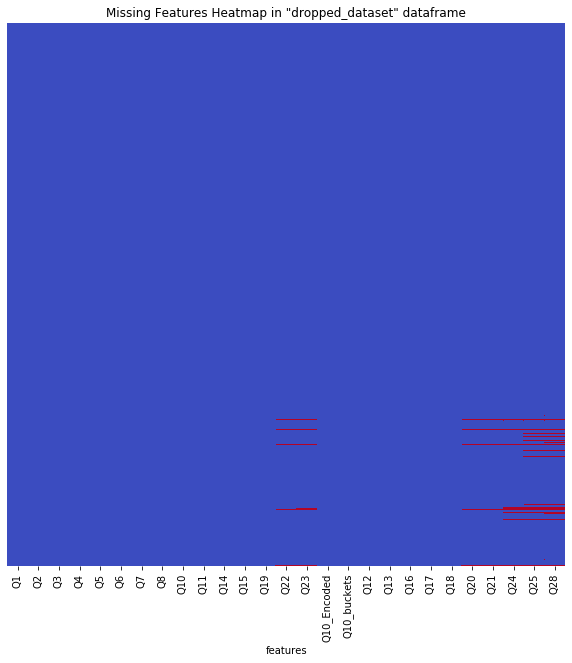

In [20]:
plt.figure(figsize=(10,10))
missing_values_heatmap = sns.heatmap(dropped_dataset.isnull(),cmap='coolwarm',yticklabels=False,cbar=False)
plt.xlabel("features")
plt.xticks(rotation=90)
plt.title('Missing Features Heatmap in "dropped_dataset" dataframe')
plt.show()

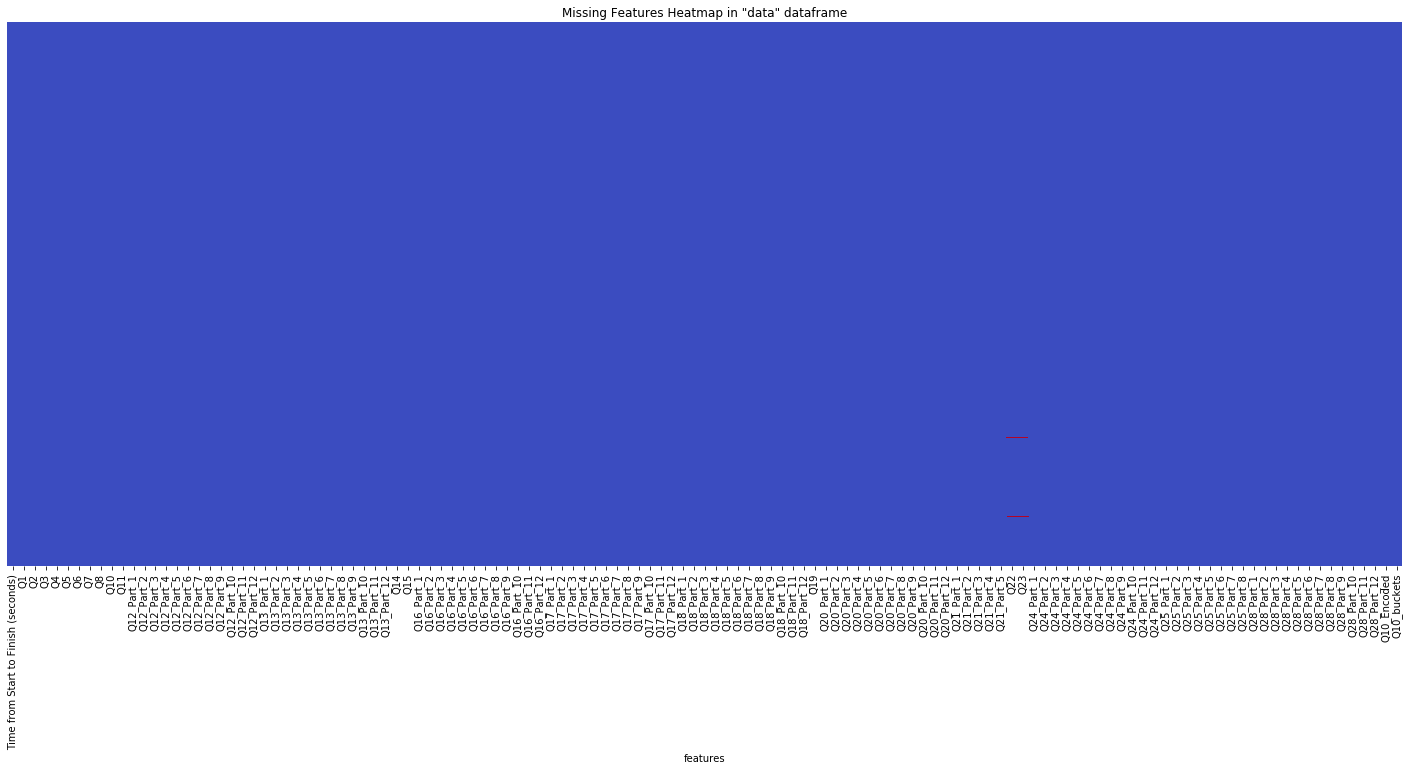

In [21]:
plt.figure(figsize=(25,10))
missing_values_heatmap = sns.heatmap(data.isnull(),cmap='coolwarm',yticklabels=False,cbar=False)
plt.xlabel("features")
plt.title('Missing Features Heatmap in "data" dataframe')
plt.xticks(rotation=90)
plt.show()

### Look specifically into these columns

As we can see from the heat map above, after dropping columns and rows, there are still small portion of missing values exist in two dataframes. Because the amount of missing values at current stage is small, I will manually look into each column which has NAN.

Q22: Have you ever used a TPU (tensor processing unit)?

In [22]:
Q22_count = dropped_dataset['Q22'].value_counts()
Q22_count

Never         8512
Once           976
2-5 times      795
6-24 times     145
> 25 times     122
Name: Q22, dtype: int64

In [0]:
dropped_dataset['Q22'] = dropped_dataset['Q22'].fillna('Never')
data['Q22']=data['Q22'].fillna('Never')

Q23: For how many years have you used machine learning methods?

In [24]:
Q23_count = dropped_dataset['Q23'].value_counts()
Q23_count

< 1 years      3068
1-2 years      2727
2-3 years      1569
3-4 years       975
4-5 years       863
5-10 years      833
10-15 years     330
20+ years       176
Name: Q23, dtype: int64

In [0]:
dropped_dataset['Q23'] = dropped_dataset['Q23'].fillna('< 1 years')
data['Q23'] = data['Q23'].fillna('< 1 years')

Q20: What data visualization libraries or tools do you use on a regular basis?  (Select all that apply) 

In [0]:
dropped_dataset['Q20'] = dropped_dataset['Q20'].fillna(0)

Q21: Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice - CPUs

In [0]:
dropped_dataset['Q21'] = dropped_dataset['Q21'].fillna(0)

Q24: Which of the following ML algorithms do you use on a regular basis? (Select all that apply): 

In [0]:
dropped_dataset['Q24'] = dropped_dataset['Q24'].fillna(0)

Q25: Which categories of ML tools do you use on a regular basis?  (Select all that apply)

In [0]:
dropped_dataset['Q25'] = dropped_dataset['Q25'].fillna(0)

Q28: Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) 

In [0]:
dropped_dataset['Q28'] = dropped_dataset['Q28'].fillna(0)

Change value type in 'dropped_dataset' from float to int.

In [0]:
column_list_=['Q12','Q13','Q16','Q17','Q18','Q20','Q21','Q24','Q25','Q28']
for _column_ in column_list_:
  dropped_dataset[_column_] = dropped_dataset[_column_].astype(int)

By this stage, all missing values are properly handled, next step is encoding questions which do have multiparts.

###Simplify Data

Before we encode non-multi part questions, I decided to simplify Data first in order to reduce the amount of output columns from pd.get_dummies

#### Simplify Age

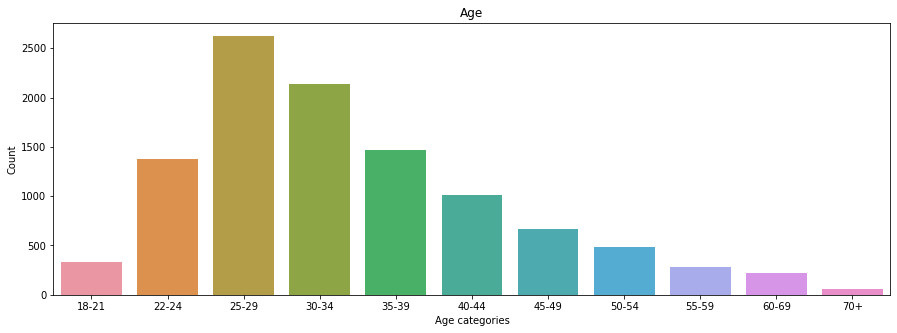

In [32]:
Age_group = data['Q1'].value_counts().to_dict()
Age_group_ordered = sorted(Age_group.keys())
plt.figure(figsize=(15,5))
graph_gender = sns.countplot(x='Q1',data=data,order=Age_group_ordered).set_title("Age")
plt.ylabel("Count")
plt.xlabel("Age categories")
plt.show()

After visualized the age distribution, I thought 11 age groups are not necessary so I decided to simplify the age group into 6 groups: 18-24; 25-29; 30-34; 35-44; 45-54; 55-70+

In [0]:
data['Q1'] = data['Q1'].replace('18-21','18-24')
data['Q1'] = data['Q1'].replace('22-24','18-24')
data['Q1'] = data['Q1'].replace('35-39','35-44')
data['Q1'] = data['Q1'].replace('40-44','35-44')
data['Q1'] = data['Q1'].replace('45-49','45-54')
data['Q1'] = data['Q1'].replace('50-54','45-54')
data['Q1'] = data['Q1'].replace('55-59','55-70+')
data['Q1'] = data['Q1'].replace('60-69','55-70+')
data['Q1'] = data['Q1'].replace('70+','55-70+')

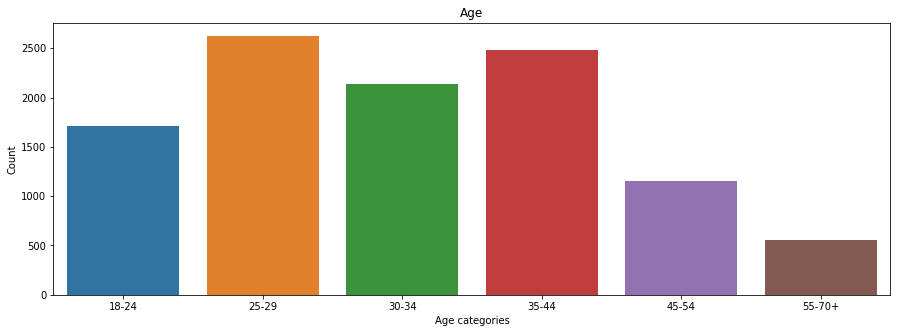

In [34]:
Age_group = data['Q1'].value_counts().to_dict()
Age_group_ordered = sorted(Age_group.keys())
plt.figure(figsize=(15,5))
graph_gender = sns.countplot(x='Q1',data=data,order=Age_group_ordered).set_title("Age")
plt.ylabel("Count")
plt.xlabel("Age categories")
plt.show()

#### Simplify Counties

Visulize the number of surveyee count from each country.

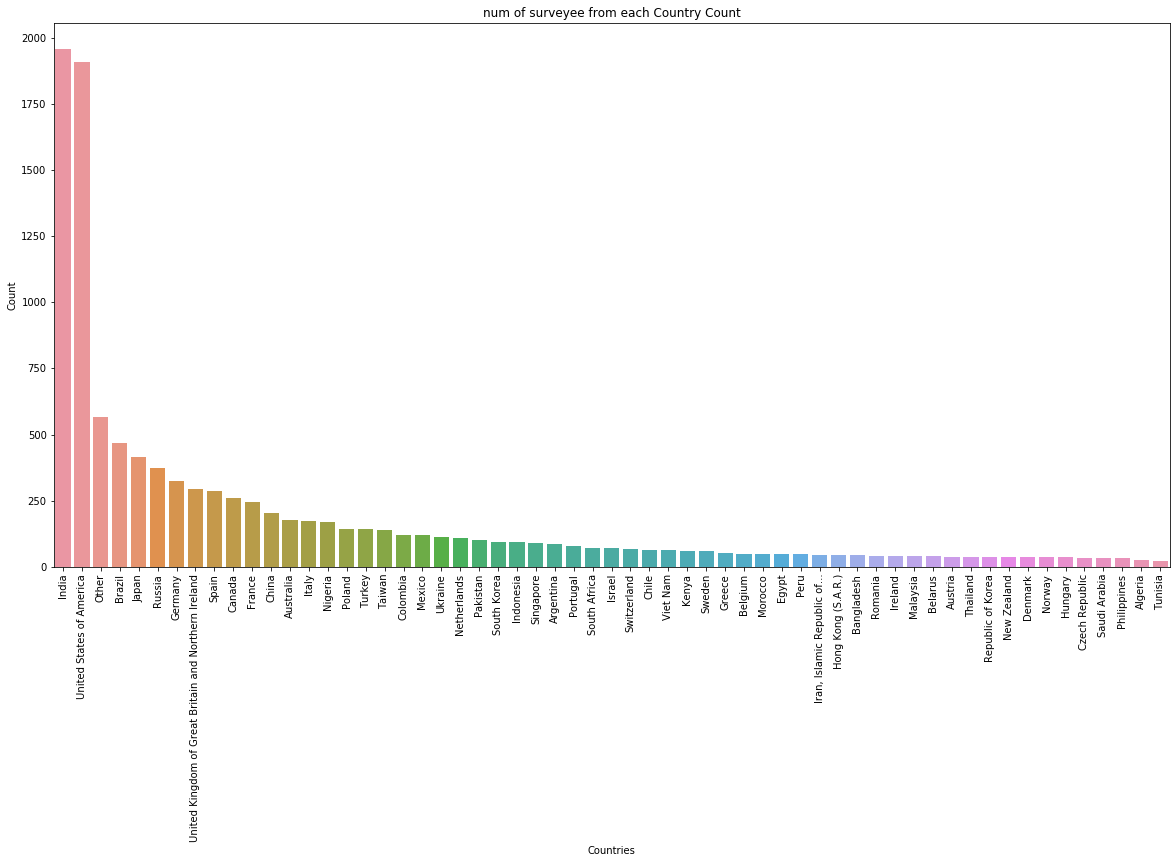

There are total: 59 counties


In [35]:
Country_counts = data['Q3'].value_counts()
sorting = (Country_counts.index)
plt.figure(figsize=(20,10))
country_plot = sns.countplot(x='Q3',data=data,order=sorting).set_title('num of surveyee from each Country Count')
plt.ylabel("Count")
plt.xlabel("Countries")
plt.xticks(rotation=90)
plt.show()
print("There are total:",len(Country_counts.index),"counties")

There are 59 countries in total, but most of them are less than 250 counts, in order to reduce the amount of output columns from pd.get_dummies function, I decided to combine those countries (count < 100) into a new group called "Combined_Countries" 

In [0]:
trans_= data['Q3'].isin(sorting[Country_counts<100])
data.loc[trans_,'Q3'] = "Combinded_Countries"

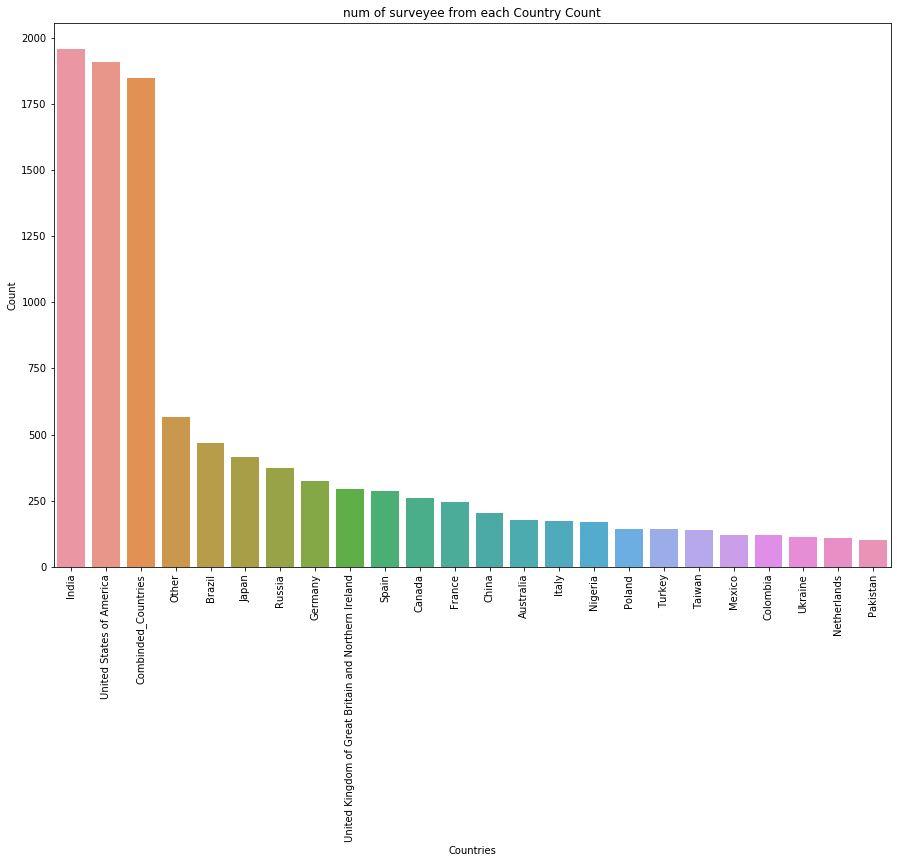

There are total: 24 counties


In [37]:
Country_counts = data['Q3'].value_counts()
sorting = (Country_counts.index)
plt.figure(figsize=(15,10))
country_plot = sns.countplot(x='Q3',data=data,order=sorting).set_title('num of surveyee from each Country Count')
plt.ylabel("Count")
plt.xlabel("Countries")
plt.xticks(rotation=90)
plt.show()
print("There are total:",len(Country_counts.index),"counties")

Thus, I reduced the amount of countries in our data from 59 to 24. This step can aviod sparse data if we gonna use pd.get_dummies function.

##Encoding Non_multi_parts Questions

In this section, I will encode the non-multi-part questions. They basically have two types of data we need to consider:


1.   Data with ordinal relationship
2.   Data without ordinal relationship

After carefully go through the raw dataset, I filtered out these two types of questions. For questions with ordinal relationship, I will use Ordinal encoding method. On the other hand, for the questions without ordinal relationship, I will use nominal encoding method.



#### Nominal Encoding

Here are all questions that need to be encoded by Nominal encoding method. They do not have ordinal relationship.

In [0]:
Q2_dummies = pd.get_dummies(data['Q2'],prefix='Q2')#Gender
Q3_dummies = pd.get_dummies(data['Q3'],prefix='Q3')#Country
Q4_dummies = pd.get_dummies(data['Q4'],prefix='Q4')#Degree
Q5_dummies = pd.get_dummies(data['Q5'],prefix='Q5')#current role
Q8_dummies = pd.get_dummies(data['Q8'],prefix='Q8')#incoop with ML
Q14_dummies = pd.get_dummies(data['Q14'],prefix='Q14')#primary tool
Q19_dummies = pd.get_dummies(data['Q19'],prefix='Q19')#programming language
Q22_dummies = pd.get_dummies(data['Q22'],prefix='Q22')#used TPU

#### Ordinal Encoding

For q1,q6,q7,q11,q15,q23 specifically, these questions have ordinal relationship, so that we need to use ordinal encoding method.

In [0]:
Q1_label={'18-24':0,'25-29':1,'30-34':2, '35-44':3, '45-54':4, '55-70+':5}
data.loc[0:,'Q1_Encoded'] =data.loc[0:,'Q1'].map(Q1_label)
data['Q1_Encoded']=data['Q1_Encoded'].astype(int)
data.drop(['Q1'],axis=1,inplace=True)

In [0]:
Q6_label={'0-49 employees':0,'50-249 employees':1,'250-999 employees':2,'1000-9,999 employees':3, '> 10,000 employees':4}
data.loc[0:,'Q6_Encoded'] =data.loc[0:,'Q6'].map(Q6_label)
data['Q6_Encoded']=data['Q6_Encoded'].astype(int)
data.drop(['Q6'],axis=1,inplace=True)

In [0]:
Q7_label={'0':0,'1-2':1,'3-4':2,'5-9':3,'10-14':4,'15-19':5,'20+':6}
data.loc[0:,'Q7_Encoded'] =data.loc[0:,'Q7'].map(Q7_label)
data['Q7_Encoded']=data['Q7_Encoded'].astype(int)
data.drop(['Q7'],axis=1,inplace=True)

In [0]:
Q11_label={'$0 (USD)':0,'$1-$99':1,'$100-$999':2,'$1000-$9,999':3,'$10,000-$99,999':4,'> $100,000 ($USD)':5}
data.loc[0:,'Q11_Encoded'] =data.loc[0:,'Q11'].map(Q11_label)
data['Q11_Encoded']=data['Q11_Encoded'].astype(int)
data.drop(['Q11'],axis=1,inplace=True)

In [0]:
Q15_label={'< 1 years':0,'1-2 years':1,'3-5 years':2,'5-10 years':3,'10-20 years':4,'20+ years':5}
data.loc[0:,'Q15_Encoded'] =data.loc[0:,'Q15'].map(Q15_label)
data['Q15_Encoded']=data['Q15_Encoded'].astype(int)
data.drop(['Q15'],axis=1,inplace=True)

In [0]:
Q23_label={'< 1 years':0,'1-2 years':1,'2-3 years':2,'3-4 years':3,'4-5 years':4,'5-10 years':5,
           '10-15 years':6,'20+ years':7}
data.loc[0:,'Q23_Encoded'] =data.loc[0:,'Q23'].map(Q23_label)
data['Q23_Encoded']=data['Q23_Encoded'].astype(int)
data.drop(['Q23'],axis=1,inplace=True)

## Completely cleaned dataset

'drop_zero' function here mainly to deal with multi-parts questions 'None' colmn. Because previously, I convert 'None' to 0. Which means the 'None' column entirely are all zeros inside. Thus, I decided to drop these columns because they only contains zeros.

In [0]:
def drop_zero(dataframe):
  for column in dataframe.columns:
    if (dataframe[column].sum())==0:
      dataframe = dataframe.drop([column],axis=1)
  return dataframe

Build completely dataframe here, dropping unnecessary columns.

In [0]:
dummy_data = pd.concat([Q2_dummies,Q3_dummies,Q4_dummies,Q5_dummies,Q8_dummies,Q14_dummies,Q19_dummies,Q22_dummies],axis=1)
#drop Time column, and build all data togther to a dataframe.
data.drop(['Time from Start to Finish (seconds)'],axis=1,inplace=True)
cleaned_data = pd.concat([dummy_data,data],axis=1)
cleaned_data.drop(['Q2','Q3','Q4','Q5','Q8','Q14','Q19','Q22','Q10_buckets','Q10'],axis=1,inplace=True)
#Move target column to the end
cols_ = list(cleaned_data.columns.values)
cols_.pop(cols_.index('Q10_Encoded'))
cleaned_data = cleaned_data[cols_+['Q10_Encoded']]

In [0]:
cleaned_data = drop_zero(cleaned_data)

In [48]:
cleaned_data.shape

(10653, 181)

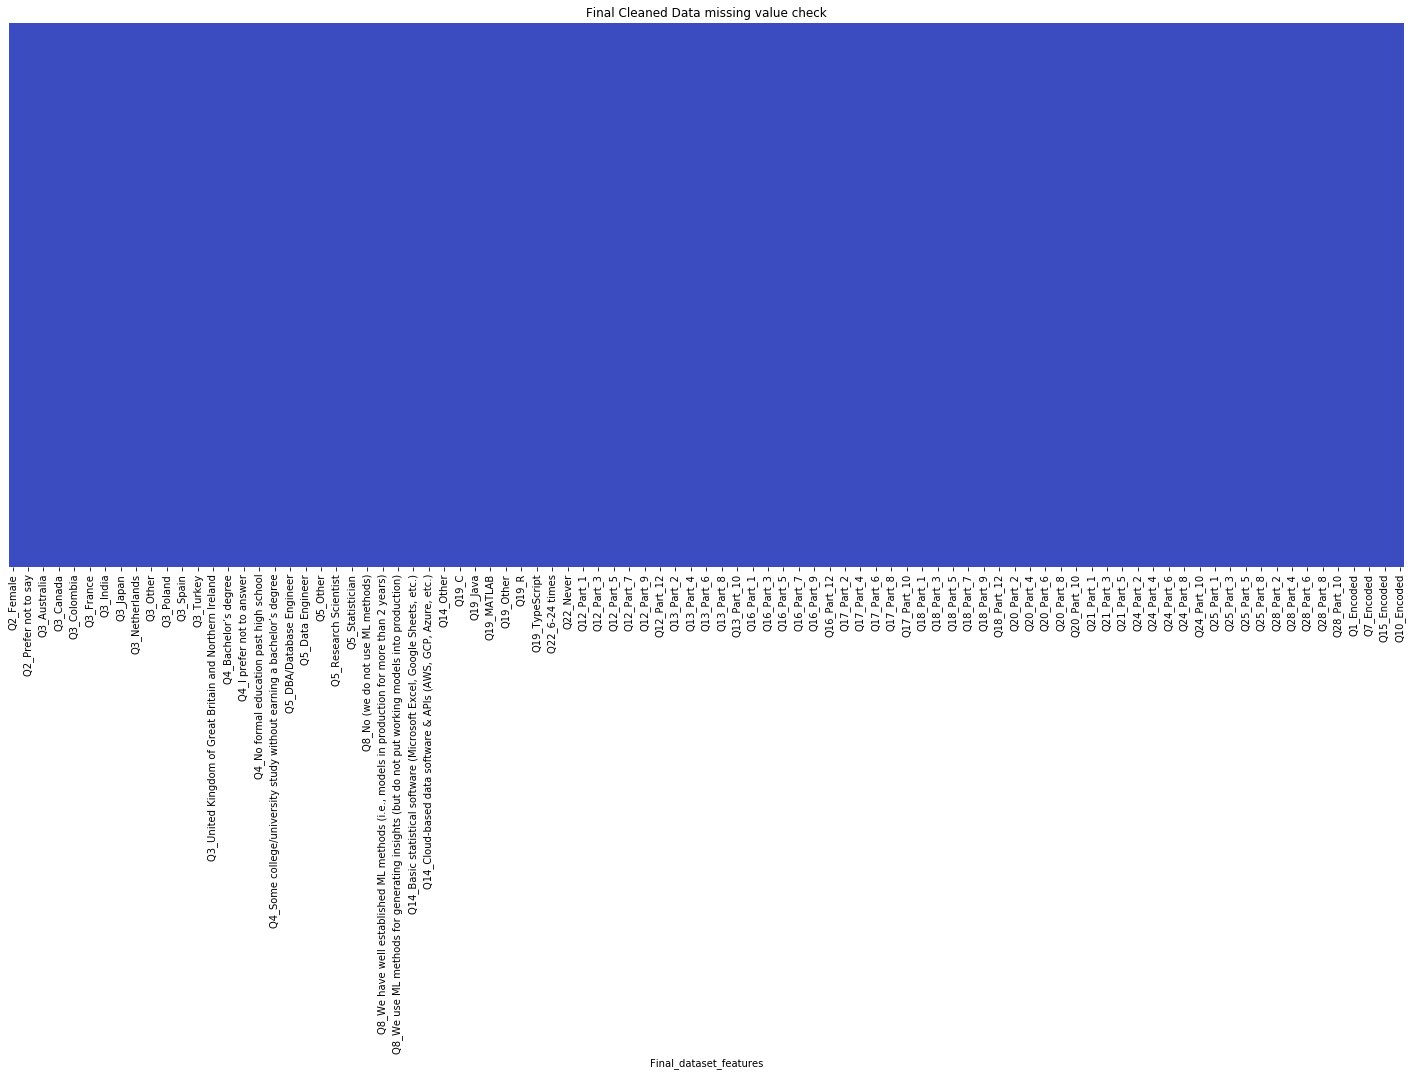

In [49]:
plt.figure(figsize=(25,10))
Final_cleaned = sns.heatmap(cleaned_data.isnull(),cmap='coolwarm',yticklabels=False,cbar=False)
plt.xlabel("Final_dataset_features")
plt.title('Final Cleaned Data missing value check')
plt.xticks(rotation=90)
plt.show()

Final check

In [50]:
cleaned_data.isnull().sum().sum()

0

# Exploratory data analysis

In this section, Exploratory data analysis is performed here to find interesting trends in the dataset. To begin, I plotted a correlation matrix to show the hidden relationship inside my cleaned dataset. However, due to huge amount of feature, correlation matrix may not describe or successfully visulize the features importance. 

Thus, I got the second plot: salary (Q10_encoded) row from correlation graph, this is basically feature importance graph with respect to salary(target).



## Correlation Matrix of cleaned dataset

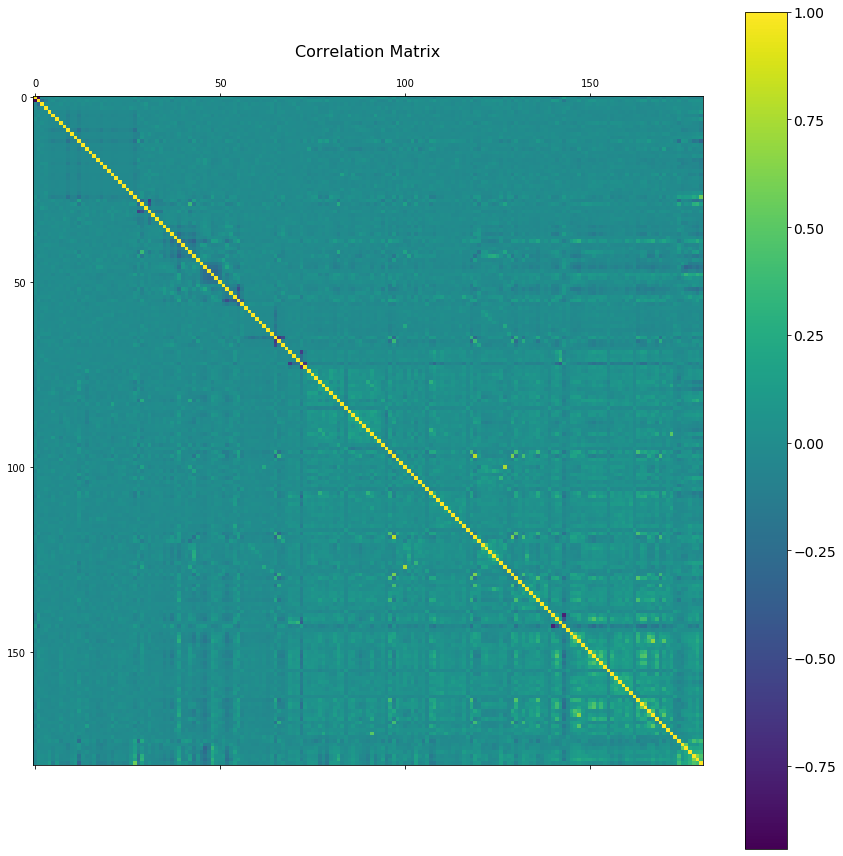

In [51]:
f = plt.figure(figsize=(15, 15))
plt.matshow(cleaned_data.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

## Correlation Plot with respect to salary

This graph demonstrates the importance of each feature related to target column. Based on the results, we can see that the highest correlation is USA, which indication that whether you work in USA or not has huge impact on your salary. Second strongest correlation is Q15_Encoded, which means that "How long have you been writing code to analyze data (at work or at school)?" can also influence salary a lot. I plotted top 50 features importance regarding to salary target. The top five features are:


1.   whether you work in USA?
2.   How long have you been writing code to analyze data (at work or at school)?
3.   For how many years have you used machine learning methods?
4.   What is your age?
5.   how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?






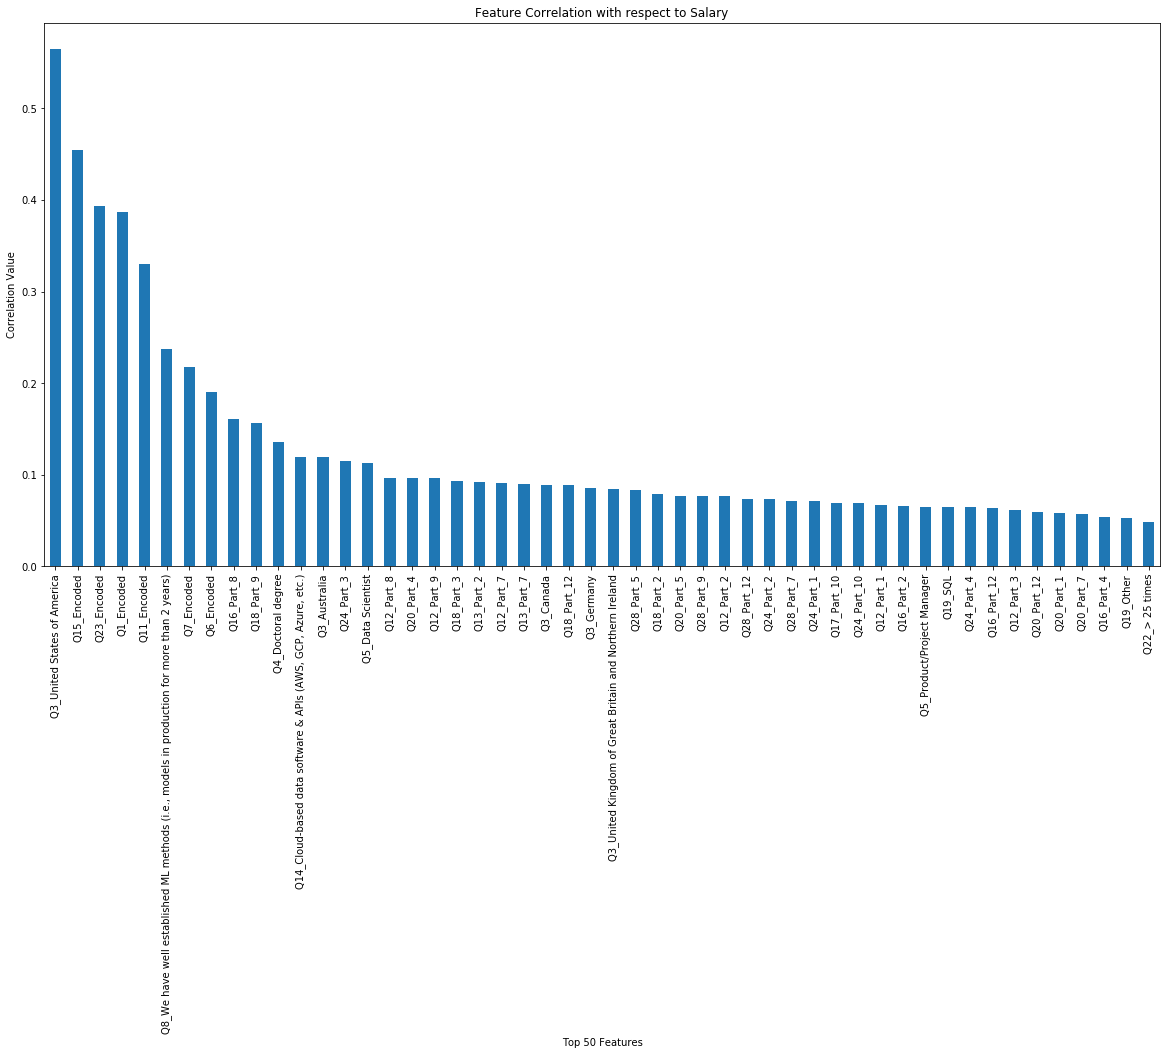

In [52]:
correlation_plot = cleaned_data.corr()
salary_index = correlation_plot.shape[0]-1
correlation = correlation_plot.iloc[salary_index,0:-1].sort_values(ascending=False)
# show top 50 correlations with salary
plt.subplots(figsize=(20,10))
correlation.iloc[0:50].plot(kind='bar')
plt.title('Feature Correlation with respect to Salary')
plt.xlabel('Top 50 Features')
plt.ylabel('Correlation Value')
plt.show()

## Three graphical figures that represent trends in the data

###1. Working Location VS salary

As I stated before, whether you work in USA strongly impact your salary, thus, we can extend our vision that this feature ultimately asks surveyee where to work. It makes sense to take look how different working location/different countries affect salary. Below i plotted different countris vs salary graph.

**Note:**

*   The y-axis label is salary encoded, acutral meaning of these number can refered to the provided assignment file.




**Results:** For those who work in the USA have highest salary earning compare to other countries. Australia and UK with second and third most incomes. China, Taiwan, Turkey, Colombia earn the least.

<Figure size 2160x2160 with 0 Axes>

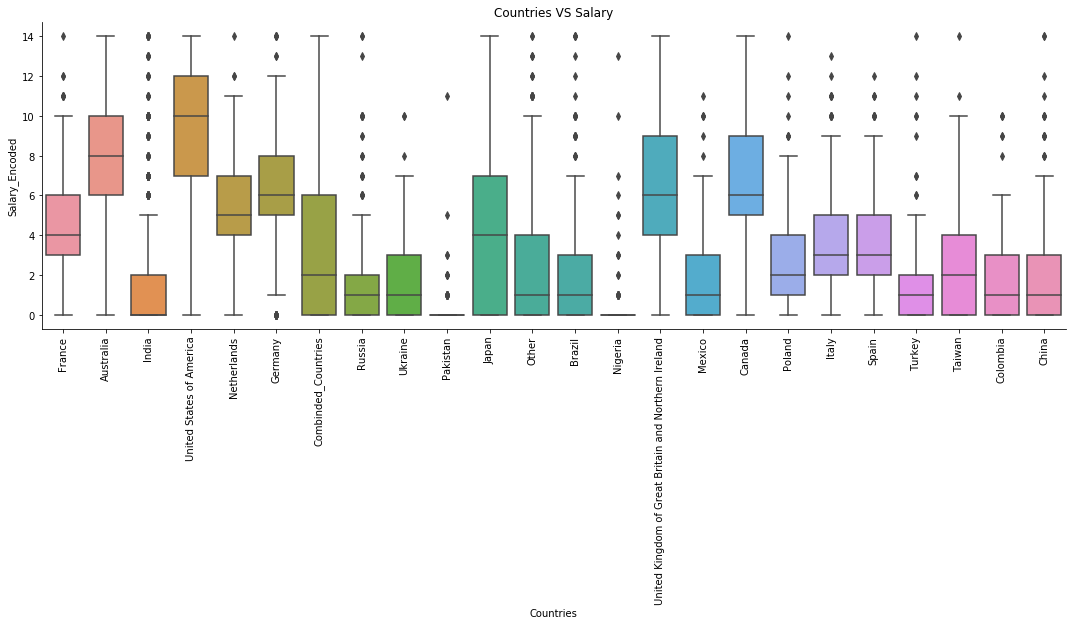

In [53]:
plt.figure(figsize=(30,30))
country_salary = sns.catplot(x='Q3',y='Q10_Encoded',data=data,kind='box',height=5, aspect=3)
country_salary.set_axis_labels("Countries", "Salary_Encoded")
plt.title("Countries VS Salary")
plt.xticks(rotation=90)
plt.show()

### 2. Years of writing code to analyze data vs. Salary

The second strongest correlation feature with salary target is "How long have you been writing code to analyze data ?". Therefore, I plotted a graph showing that "years of writing code vs salary" below. 

**Note:**

*   The x-axis label is encoded, actual meaning are listed here :

      < 1 years': 0;
  
      '1-2 years': 1;
    
      '3-5 years': 2;  
    
      '5-10 years': 3;  
    
     '10-20 years': 4;  
    
      '20+ years': 5;
*   The y-axis label is salary encoded, acutral meaning of these number can refered to the provided assignment file.





**Results:** We can simply observe the trend is with more years of experience , the more salary earns.

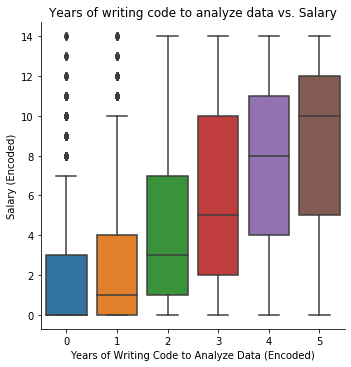

In [54]:
# plot years of writing code to analyze data
experience = sns.catplot(x='Q15_Encoded', y='Q10_Encoded', data=data, kind="box")
experience.set_axis_labels("Years of Writing Code to Analyze Data (Encoded)", "Salary (Encoded)")
plt.title("Years of writing code to analyze data vs. Salary")
plt.show()

### 3. Years of ML experience vs. Salary

The third important feature which affect salary is:"For how many years have you used machine learning methods?" I plotted a graph called "years of ML experience vs salary"

**Note:**

*   The x-axis label is encoded, actual meaning are listed here :

  '< 1 years':  0,

  '1-2 years':  1,

  '2-3 years':  2,

  '3-4 years':  3,

  '4-5 years':  4,

  '5-10 years':  5,

  '10-15 years':  6,

  '20+ years':   7
*   The y-axis label is salary encoded, acutral meaning of these number can refered to the provided assignment file.

**Result:** Clearly we can see that with more years of ML experience, more income.




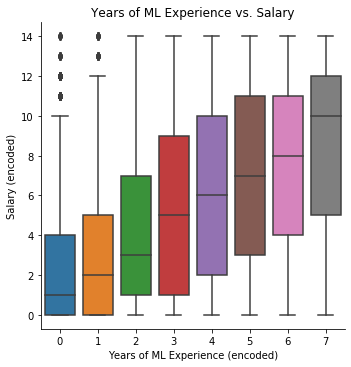

In [55]:
# plot years of ML experience
g = sns.catplot(x='Q23_Encoded', y='Q10_Encoded', data=data, kind="box")
g.set_axis_labels("Years of ML Experience (encoded)", "Salary (encoded)")
plt.title("Years of ML Experience vs. Salary")
plt.show()

# Feature Selection

Feature engineering is an essential step which need to be done before implement any ML model. The key to make robust and accurate prediction is not about which model is selected, but rather what goes in your model. If your dataset does not have a set of good features, then the end result would also be bad. A large number of features make a model time-taking, and harder to implement in production.The purpose of doing feature engineering is choose the features that are important and get rid of those meaningless/useless features. Then the selected features can be used to improve the performance of machine learning algorithms. 

In addition, feature engineering can also create new features, those new features can help/imporve the model performance.Feature creation technique used to create new features based on raw data by either splitting or combining original features.


---
Most feature selection methods can be divided into three major buckets:


1.   *Filter based*: This type of selection method assumes features are independent, assigns a score for each feature based on some statistical measurements.
2.   *Wrapper-based*: Unlike the filter based, wrapper based selection algorithm groups some feature as a combination, and performs exhaustively search with the best set of feature combination. A predictive model us used to evaluate a combination of features and assign a score based on model accuracy.
3.   *Embedded Methods*:Embedded methods learn which features best contribute to the accuracy of the model while the model is being created.







## Feature Creation

Refer to the Data cleaning part, I have created 19 combined features which are merged column from multi-parts question.

*   
        Q9_merged,Q12_merged,Q13_merged,Q16_merged,Q17_merged,Q18_merged,
        Q20_merged,Q21_merged,Q24_merged,Q25_merged,Q26_merged,Q27_merged,Q28_merged,
        Q29_merged,Q30_merged,Q31_merged,Q32_merged,Q33_merged,Q34_merged


Oringinally, those features are stored in **dropped_dataset**, but not all of them will be selected to be our new features, since in the data cleaning phrase, I have dropped some columns if this column has more than 20 percent NAN. Thus, after cleaning, the remaining merged columns are:

        ['Q12','Q13','Q16','Q17','Q18','Q20','Q21','Q24','Q25','Q28']

Therefore, after carefully went through them, intuitively, I have picked 6 features may have impact on our salary target, which are listed below.


1.   Number of hosted notebook products have you used?  **"Q17_merged"**
2.   Number of intergrated development environments have you used on a regular basis?  **"Q16_merged"**
3.   Number of programming languages do you know?**"Q18_merged"**
4.   Number of data visualization libraries or tools have you used?**"Q20_merged"**
5.   Number of ML algorithms have you used?**"Q24_merged"**
6.   Number of ML frameworks have you used?**"Q28_merged"**


These 6 new features will be added to our data set.






In [0]:
Q16_new = dropped_dataset.Q16 
Q17_new = dropped_dataset.Q17 
Q18_new = dropped_dataset.Q18 
Q20_new = dropped_dataset.Q20 
Q24_new = dropped_dataset.Q24 
Q28_new = dropped_dataset.Q28

#build a dataframe to store these new features
generated_features = pd.DataFrame(data={'Q16_new':Q16_new,'Q17_new':Q17_new, 'Q18_new':Q18_new, 'Q20_new':Q20_new,'Q24_new':Q24_new, 'Q28_new':Q28_new})

# combine with the rest of the cleaned data
cleaned_data = pd.concat([cleaned_data, generated_features], axis=1)

## Feature Selection using Principle Component Analysis (PCA)

I selected a feature selection technique called dimensional reduction. A popular dimension reduction method is known as Principle Component Analysis (PCA). Besides combining features, the created new features are independent of one another and they are ranked according to the variance among them.

A feature selection method is proposed to select a subset of variables in principal component analysis (PCA) that preserves as much information present in the complete data as possible. The information is measured by means of the percentage of consensus in generalised Procrustes analysis.

In the code below, I specified 40 as the desired amount of resultant components. Which means that the output from PCA technique will allow me to have 40 features in total. 

In [0]:
y = cleaned_data['Q10_Encoded']#target column
X = cleaned_data.drop(['Q10_Encoded'],axis=1)#ML dataset without target column

In [0]:
#standerize dataset
scaler = StandardScaler()
scaler.fit_transform(X)
X = scaler.transform(X)

In [0]:
pca = PCA(n_components = 40)
pca.fit(X)
X_final = pca.fit_transform(X)#nd array

#convert it to dataframe
X_final = pd.DataFrame(data=X_final,columns=['pca'+str(i) for i in range(X_final.shape[1])])

In [0]:
#split data into 70% training set, 30% test set
X_train, X_test, y_train, y_test = train_test_split(X_final, y, random_state=42, test_size=0.3)

# Model Implementation (Logistic Regression)

In this section, logistic regression model is implemented with PCA feature selected datasets. The results of the model are generated from 10 folders cross validation.

## 10-fold cross-validation

In K-Fold Cross Validation, the training dataset is divided in to *K* folds, and *K-1* folds. A 10 fold cross validation divides the data in to 10 parts, and the training and testing repeats for a total of 10 times (every observation from original dataset has equally chance of appearing in the training and test set). Thus, by using cross validation technique, it will generate a less biased/optimistic model.

I firstly created a Logistic model **without specifying any parameters**.

The following two code cells runs a 10 fold cross validation where the average accuracy was showed at the end. The average accuracy of each fold hovers around 32% with variance of the average accuracy approximately 1.2.

In [0]:
# 10 fold cross validation for the model trained on PCA selected features
import warnings
warnings.filterwarnings("ignore")
#create logistic model without any parameters
model = LogisticRegression()
results = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')

In [62]:
num_fold= 0
for i in results:
    score = i * 100
    num_fold += 1
    print("Fold "+ str(num_fold) + " Accuracy: " + str(round(score,2)) + "%")
average_score = results.mean()*100
score_std = results.std()*100
print("\n")
print("Average Accuracy of 10 fold cross validation: " + str(round(average_score,3))+"%") 
print("Variance of 10 folds cross validation accuracy: " + str(round(pow(score_std, 2), 2)))

Fold 1 Accuracy: 33.38%
Fold 2 Accuracy: 32.44%
Fold 3 Accuracy: 33.24%
Fold 4 Accuracy: 32.84%
Fold 5 Accuracy: 33.38%
Fold 6 Accuracy: 32.44%
Fold 7 Accuracy: 33.24%
Fold 8 Accuracy: 32.48%
Fold 9 Accuracy: 32.48%
Fold 10 Accuracy: 33.42%


Average Accuracy of 10 fold cross validation: 32.935%
Variance of 10 folds cross validation accuracy: 0.17


## Treating each value of hyperparameters as a new model

Inverse of regularization strength C is the hyperparameter of Logistic Regression, which controls how strong the regularizer is. It is used to calibrate the penalization of larger number of features to prevent overfitting. Lower lamda is adding strong penalty to model, which means the model tends to be complex, overfitt, and vice-versa. 


---
A model is underfitted when the variance low and bias high. On the contrary, a model is overfitted when the variance high and bias low.

---


In the code below, 12 models are created based on 12 different hyperparameters. The results showed that c = 0.5 is the best (the score changes with every run due to the different splits completed by PCA and random shuffling) model. At this regularization parameter, the bias and variance trade off are balanced, total error is optimized.

In [63]:
C_list = [1e-4,1e-3,1e-2,1e-1,0.5,1,5,8,10,50,100,1000]
count=0
for c in C_list:
    model= LogisticRegression(penalty = 'l2',C=c, solver='newton-cg')
    model.fit(X_train, y_train)
    count+=1
    print("Model",count, "Score: " + str(round(model.score(X_test, y_test)*100, 2)) + "%")

Model 1 Score: 29.54%
Model 2 Score: 32.1%
Model 3 Score: 32.79%
Model 4 Score: 32.95%
Model 5 Score: 32.85%
Model 6 Score: 32.88%
Model 7 Score: 32.92%
Model 8 Score: 32.92%
Model 9 Score: 32.92%
Model 10 Score: 32.92%
Model 11 Score: 32.92%
Model 12 Score: 32.92%


In [64]:
print('If treating each value of hyperparameters as a new model,')
print('The best model is it with c = 1e-1, which achieves 32.95% accuracy.')

If treating each value of hyperparameters as a new model,
The best model is it with c = 1e-1, which achieves 32.95% accuracy.


#Model Tuning

In the previous question, hyperparameters were manually assigned for each model. Here, I will implement a new technique called hyperparameter tuning by using Grid-search with cross validation.

Grid-search method can exhaustively search every single  combination with cross validation to find the best hyperparameter values for the model. 

In this case, I tuned the following:

*   penalty,
*   hyperparameter C
*   solver


For this assignment, our logistic regression model has a fixed parameter, which is multiclass = 'ovr'. In one-vs-rest logistic regression (OVR) a separate model is trained for each class predicted whether an observation is that class or not (thus making it a binary classification problem). It assumes that each classification problem (e.g. class 0 or not) is independent.

##Grid search

In [0]:
#clf = LogisticRegression()
#grid_values = {'penalty' : ['l1', 'l2'],'C' : [1e-4,1e-3,1e-2,1e-1,0.5,1,5,8,10,50,100,1000],'solver' : ['newton-cg','lbfgs','liblinear','sag'],'multi_class':['ovr']}
#grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,cv=10,scoring = 'accuracy')
#best_result = grid_clf_acc.fit(X_train, y_train)

In [66]:
#print('Best C:', best_result.best_estimator_.get_params()['C'])
#print("Best accuracy :",best_result.best_score_)
#print('Best Penalty:', best_result.best_estimator_.get_params()['penalty'])
#print('Best solver:', best_result.best_estimator_.get_params()['solver'])
#print('multi_class:', best_result.best_estimator_.get_params()['multi_class'])

Best C: 0.5
Best accuracy : 0.32452651276607225
Best Penalty: l1
Best solver: liblinear
multi_class: ovr


In [67]:
##Note: above grid search method will take massive runing time, I will hard coded to show results from above
##However, due to the random shuffling, the results change everytime when you re-run the code.
##Below just show one sample run results
print("\n")
print("I hard coded to show results for a sample run below because the run time for grid search is super long.")
print("However, due to the random shuffling, the results change everytime when you re-run the code.")
print("Best C: 0.5")
print("Best accuracy :0.3245")
print("Best Penalty: l1")
print("Best solver: liblinear")
print("Best multiclass: ovr")



I hard coded to show results for a sample run below because the run time for grid search is super long.
However, due to the random shuffling, the results change everytime when you re-run the code.
Best C: 0.5
Best accuracy :0.3245
Best Penalty: l1
Best solver: liblinear
Best multiclass: ovr


Creating best model based on the grid search result.

In [68]:
best_model = LogisticRegression(penalty='l1',C=0.5, solver='liblinear',multi_class='ovr')
best_model.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

#Testing & Discussion

With the optimal model was created and then evaluated on the test data. The following cells show the classification report for the model trained on the PCA selected dataset. The accuracy on the test set is very similar to the score from cross validation on the training set. 

So that the model has generalized very well on previously unseen data. 


##Overall performance with optimal model

In [0]:
predictions = best_model.predict(X_test)

In [70]:
final_result = classification_report(y_test, predictions,digits=4)
print(final_result)

              precision    recall  f1-score   support

           0     0.4084    0.9196    0.5656       945
           1     0.1096    0.0227    0.0376       353
           2     0.1193    0.0474    0.0679       274
           3     0.0972    0.0393    0.0560       178
           4     0.1325    0.0582    0.0809       189
           5     0.1852    0.0510    0.0800       196
           6     0.1719    0.0748    0.1043       147
           7     0.0588    0.0236    0.0337       127
           8     0.0909    0.0083    0.0153       120
           9     0.0000    0.0000    0.0000        96
          10     0.2042    0.2646    0.2305       223
          11     0.1402    0.1128    0.1250       133
          12     0.2761    0.3162    0.2948       117
          13     0.2000    0.0208    0.0377        48
          14     0.1538    0.0400    0.0635        50

    accuracy                         0.3276      3196
   macro avg     0.1565    0.1333    0.1195      3196
weighted avg     0.2169   

In addition, the classification report showed that precision/recall/f1-score are all high with the more support, on the other hand, scores decrease with low support. This makes sense as the model had more examples of low incomes compared to high incomes. Therefore, it does better on low incomes prediction than high incomes during testing for sure. 

To improve the accuracy, one way to do is that reduce the amount of classes, for example, to have 14 classes will have lower accuracy, could reduce 14 classes to 5 or 6 classes. Because the main reason why the classifier performed poorly is because of not enough samples for some classes or more samples for some classes missleading the model prediction; thus, reducing the number of classes will bring more samples into each class.

##Plot distribution

In [71]:
#Building a dataframe to plot the distribution.
plot_result_df=pd.DataFrame(y_test)
plot_result_df['pred']=predictions
plot_result_df.columns=['True','Pred']
plot_result_df.head()

,True,Pred
1410,11,10
2103,1,0
2053,6,2
7085,2,0
258,8,0


Recall the salary encode. It used to label X-axis.

In [0]:
salary_encode = {   '$0-9999': 0,
    '10,000-19,999': 1,
    '20,000-29,999': 2,
    '30,000-39,999': 3, 
    '40,000-49,999': 4, 
    '50,000-59,999': 5,
    '60,000-69,999': 6,
    '70,000-79,999': 7, 
    '80,000-89,999': 8, 
    '90,000-99,999': 9,
    '100,000-124,999':10,
    '125,000-149,999':11,
    '150,000-199,999':12,
    '200,000-249,999':13,
    '>250,000':14}

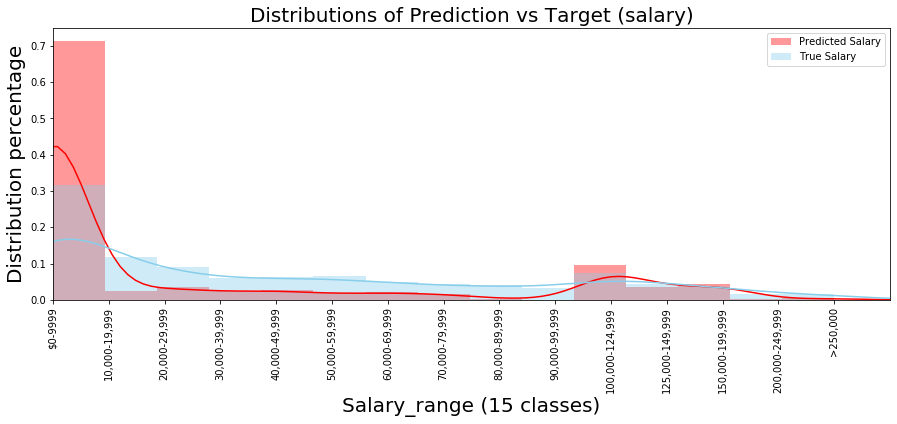

In [73]:
f, ax = plt.subplots(figsize=(15,5))
g=sns.distplot( plot_result_df['Pred'], bins=15,  color="red",label='Predicted Salary')
ax=sns.distplot( plot_result_df['True'], bins=15, color="skyblue",label='True Salary')
plt.xlim(0,15)
g.set_xticklabels(salary_encode.keys())
ax.set_xticks(range(15))
plt.xticks(rotation=90)

ax.axes.set_title('Distributions of Prediction vs Target (salary)',fontsize=20)
ax.set_xlabel('Salary_range (15 classes)',fontsize=20)
ax.set_ylabel('Distribution percentage',fontsize=20)
plt.legend()
plt.show()

##Discussion and Conclusion

Generally, the model is overpredicting the low salaries, and under predicting the high salaries. This is due to that the majority of the training data fell within this range and with less or few training data for the remaining classes.

The distribution of the predicted salaries and the actual salaries target basically have similar trend. They are similar with the majority of predictions falling the in the "0-19,999" range. For 0-19,999 range both of them are higher than the others classes, meaning we have more samples for lower incomes less sample for higher salary range.  

The model performance not really good, it generally overpredicts the the salary . As we can see from the histogram distribution, it is shown that the predicted value (red) is generally higher than the true target (blue). This means that the model is over predicting. 





## Possible Improvement

As for the future works, the logistic regression model can be improved by either having more samples to let each salary range have evenly support samples, or by simply reducing the amount of classes. 

On the other hand, we can implement more complex model such as DNN, DL, XGBoost.